<a href="https://colab.research.google.com/github/BrajanNieto/MISTI/blob/main/2026MISTIPeru_ModelValidation_NeuralNetworks_EXERCISES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**If you haven't already, please hit :**

`File` -> `Save a Copy in Drive`

**to copy this notebook to your Google drive, and work on a copy. If you don't do this, your changes won't be saved!**

# Model Validation with Neural Networks

**Make sure you change runtime type to GPU! Today is computationally intensive.**

You can use a free GPU/TPU through CoLab for faster training!
Go to Runtime --> Change runtime type --> GPU or TPU

## Import Packages

In [1]:
# ----------------------------
# ENVIRONMENT SETUP & LIBRARIES
# ----------------------------

# We comment out the IPython magic commands to ensure the code remains compatible with non-IPython environments.
# (Uncomment when running inside a Jupyter notebook if needed.)

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data as data_utils

# Installing additional visualization and PyTorch utility tools (comment out if already installed).
!pip install livelossplot
!pip install pytorchtools

# -------------
# DATA HANDLING
# -------------
import pandas as pd  # For data analysis and manipulation
import numpy as np   # For numerical operations and array manipulation
from livelossplot import PlotLosses  # For real-time plotting of loss/metrics in training
from livelossplot.outputs import MatplotlibPlot

# ------------
# VISUALIZATION
# ------------
# %matplotlib inline  # Uncomment in Jupyter notebooks for inline plots
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl  # Sometimes used for interactive plotting

# ----------------
# CROSS-VALIDATION
# ----------------
from sklearn.model_selection import (
    GridSearchCV,      # Hyperparameter tuning using exhaustive search
    train_test_split,  # Splitting data into train and test sets
    cross_val_predict, # Generating cross-validated estimates for each input data point
    cross_val_score,   # Evaluating a score by cross-validation
    KFold              # K-Fold cross-validator
)
from sklearn import model_selection

# ---------------------
# PARALLEL PROCESSING
# ---------------------
from joblib import Parallel, delayed  # For parallel execution of tasks
import multiprocessing                # Provides multiprocessing primitives

# -------------
# MISC SETTINGS
# -------------
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

# Set a manual seed for reproducibility across different runs/environments.
random_seed = 1
torch.manual_seed(random_seed)

# Extra Packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

## Prepping the Notebook for Training Neural Networks

First, we activate the GPU.

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device")

Using cuda device


Next, we create smaller subsets of the MNIST dataset for training, validation, and testing, then set up corresponding PyTorch DataLoaders to streamline batch processing during model training and evaluation.

In [3]:
# -----------------------------------------
# Define subset indices for train and test
# -----------------------------------------
train_indices = torch.arange(2500)
# Optional subset for a larger training set (currently commented out):
# tr_10k = data_utils.Subset(tr, indices)

# Create a training subset from the MNIST training set
train_set = data_utils.Subset(
    torchvision.datasets.MNIST(
        'sample_data/',            # Local directory for storing/loading data
        train=True,                # Use the training portion of MNIST
        download=True,             # Automatically download if not present
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),                       # Convert images to Tensor
            torchvision.transforms.Normalize((0.1307,), (0.3081,))   # Normalize with MNIST statistics
        ])
    ),
    train_indices                 # The indices that define the smaller training subset
)

# Define subset indices for testing
test_indices = torch.arange(250)

# Create a testing subset from the MNIST testing set
test_set = data_utils.Subset(
    torchvision.datasets.MNIST(
        'sample_data/',            # Local directory for storing/loading data
        train=False,               # Use the test portion of MNIST
        download=True,             # Automatically download if not present
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))  # Same normalization as training
        ])
    ),
    test_indices                  # The indices that define the smaller testing subset
)

# ---------------------------------------------
# Create validation split from the train subset
# ---------------------------------------------
indices = [i for i in range(2500)]  # We'll train on 2,500 images total
rand1, rand2 = train_test_split(indices, test_size=0.2, random_state=1, shuffle=True)
train_sample = SubsetRandomSampler(rand1)  # 80% of indices
val_sample = SubsetRandomSampler(rand2)    # 20% of indices

batch_size = 64

# -------------------
# Create Data Loaders
# -------------------
train_loader = torch.utils.data.DataLoader(
    train_set,
    sampler=train_sample,
    batch_size=batch_size
)
val_loader = torch.utils.data.DataLoader(
    train_set,
    sampler=val_sample,
    batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.55MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.29MB/s]


Below is a simple fully-connected neural network class that uses two linear layers for classification tasks, demonstrating how to build and forward-pass data through a PyTorch model.

In [4]:
class FullyConnectedNetwork(nn.Module):
    def __init__(self, n_features=784, hidden_size=32):
        """
        Initialize a fully-connected neural network with:
          - An input layer mapped to a hidden layer
          - A second layer that outputs 10 logits (e.g., for 10-class classification)
        """
        super(FullyConnectedNetwork, self).__init__()

        # First linear layer: reduces input dimension (n_features) to hidden_size
        self.layer0 = nn.Linear(n_features, hidden_size)

        # Second linear layer: reduces hidden_size to 10 (common for MNIST-like 10-class problems)
        self.layer1 = nn.Linear(hidden_size, 10)

    def forward(self, input_data):
        """
        Forward pass for the network:
          1. Apply ReLU activation on output of layer0
          2. Pass activated output to layer1
          3. Apply log_softmax to get log probabilities for each class
        """
        # Apply ReLU to the output of the first layer
        x = F.relu(self.layer0(input_data))

        # Pass the activated output through the second layer
        x = self.layer1(x)

        # Apply log_softmax activation on the final outputs
        # (default dim=1 for batch-first format)
        return F.log_softmax(x, dim=1)


In this section, we define essential training hyperparameters, instantiate our fully-connected network, move it to the chosen device (CPU or GPU), configure the optimizer, and finally print out the model’s architecture.

In [5]:
# ---------------
# HYPERPARAMETERS
# ---------------
n_epochs = 3              # Number of times to iterate over the entire dataset
batch_size_train = 64     # Mini-batch size for training
batch_size_test = 1000    # Mini-batch size for testing
learning_rate = 0.01      # Initial learning rate for the optimizer
momentum = 0.5            # Momentum factor for SGD
log_interval = 10         # Frequency of logging training status

# ---------------------
# MODEL INITIALIZATION
# ---------------------
# Create an instance of the fully-connected network defined previously
fc_network = FullyConnectedNetwork()

# Move the model to the specified device (CPU or GPU)
fc_network.to(device)

# ----------------
# OPTIMIZER SETUP
# ----------------
# Use Stochastic Gradient Descent with the given learning rate and momentum
fc_optimizer = optim.SGD(fc_network.parameters(), lr=learning_rate, momentum=momentum)

# --------------------------------
# INSPECTION: PRINT MODEL LAYERS
# --------------------------------
print(fc_network)

FullyConnectedNetwork(
  (layer0): Linear(in_features=784, out_features=32, bias=True)
  (layer1): Linear(in_features=32, out_features=10, bias=True)
)


In this section, we define a training function that handles the forward pass, loss computation, backpropagation, and optimization steps for each batch, while also providing periodic loss reporting during the epoch.

In [6]:
# -------------------------
# TRAINING FUNCTION DEFINED
# -------------------------
# Note: network.train() sets the model to training mode, which can enable
# specific layers (e.g., Dropout or BatchNorm) to behave differently
# compared to evaluation mode.

def train(network, optimizer, epoch, trainloader, flatten_data=True):
    """
    Trains the given network for one epoch on the provided DataLoader.

    Args:
        network: The neural network model to be trained.
        optimizer: The optimizer used (SGD, Adam, etc.) to update model weights.
        epoch: The current epoch number (used for reporting).
        trainloader: DataLoader that provides (data, target) batches.
        flatten_data: If True, reshapes data from (batch, channels, height, width)
                      to (batch, -1), which is often required for fully connected layers.

    Returns:
        loss_logs: A list of tuples containing the total number of processed examples
                   and the corresponding loss at logging intervals.
    """
    network.train()       # Ensure the model is in training mode
    loss_logs = list()

    for batch_idx, (data, target) in enumerate(train_loader):

        # Optionally flatten the data for a fully connected layer
        if flatten_data:
            data = flatten(data)

        # For convenience in referencing lengths
        num_batches = len(trainloader)
        size = len(trainloader.dataset)

        # Move data and target tensors to the chosen device (CPU or GPU)
        data, target = data.to(device), target.to(device)

        # Zero out the gradients from the previous iteration
        optimizer.zero_grad()

        # Forward pass: compute output of the network
        output = network(data)

        # Compute loss using Negative Log Likelihood (common for classification)
        loss = F.nll_loss(output, target)

        # Backward pass: compute gradients
        loss.backward()

        # Optimization step: update model parameters
        optimizer.step()

        # Log progress at specified intervals
        if batch_idx % log_interval == 0:
            examples_shown = batch_idx * len(data)
            total_examples = len(train_loader.dataset)
            fraction_shown = round(examples_shown / total_examples * 100., 2)
            rounded_loss = round(loss.item(), 4)
            print(f'Train Epoch {epoch} Progress: {fraction_shown}%\tLoss: {rounded_loss}')

            # Track the total examples seen so far in all epochs plus current batch
            examples_so_far = batch_idx * batch_size_train + epoch * len(train_loader.dataset)
            loss_logs.append((examples_so_far, loss.item()))

    return loss_logs

Here is a convolutional neural network (ConvNet) architecture with two convolutional layers (each followed by max-pooling, and the second by dropout), as well as two fully connected layers, designed for image classification tasks like MNIST.

In [7]:
class ConvNet(nn.Module):
    def __init__(self):
        """
        Initializes a two-layer convolutional neural network with dropout and
        two fully connected layers. Ideal for classification tasks such as MNIST.
        """
        super(ConvNet, self).__init__()

        # First convolution: input = 1 channel (e.g., grayscale image),
        # output = 10 channels, kernel = 5x5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)

        # Second convolution: input = 10 channels, output = 20 channels, kernel = 5x5
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)

        # 2D dropout (often used after convolutions to reduce overfitting)
        self.conv2_drop = nn.Dropout2d()

        # First fully connected layer: maps 320 features to 50
        self.fc1 = nn.Linear(in_features=320, out_features=50)

        # Second fully connected layer: maps 50 features to 10 (e.g., 10 classes for MNIST)
        self.fc2 = nn.Linear(in_features=50, out_features=10)

    def forward(self, x):
        """
        Defines the forward pass through the network layers:
          1) Conv1 + ReLU + MaxPool
          2) Conv2 + Dropout + MaxPool + ReLU
          3) Flatten and pass through two fully connected layers
          4) Apply log_softmax for classification probability outputs
        """
        # First convolution, followed by ReLU activation and 2x2 max-pooling
        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # Second convolution, followed by dropout
        x = self.conv2_drop(self.conv2(x))

        # 2x2 max-pooling
        x = F.max_pool2d(x, 2)

        # Another ReLU activation
        x = F.relu(x)

        # Flatten the feature map into a vector of size (batch, 320)
        x = x.view(-1, 320)

        # Pass the flattened output through the first fully connected layer + ReLU
        x = F.relu(self.fc1(x))

        # Apply dropout in training mode
        x = F.dropout(x, training=self.training)

        # Pass through the final fully connected layer
        x = self.fc2(x)

        # Return log probabilities (useful for classification tasks)
        return F.log_softmax(x, dim=1)


Below is a utility function that reshapes a batch of 2D MNIST images (each 28×28) into a 1D vector of 784 elements, allowing them to be processed by a fully connected layer.

In [8]:
#! Fully connected networks can't take 2D images directly, so we flatten each image into a long vector.
def flatten(batch):
    """
    Flattens a batch of images from shape (batch_size, 1, 28, 28)
    into (batch_size, 784).

    Args:
        batch (torch.Tensor): A batch of images of shape (B, C, H, W).

    Returns:
        torch.Tensor: A batch of images of shape (B, 784).
    """
    flat_batch = batch.reshape((batch.shape[0], 784))
    return flat_batch

Below is a flexible, multi-layer fully-connected network (MLP) that allows you to specify the number of hidden layers and hidden nodes. It uses ReLU for activation and is suitable for classification tasks such as MNIST.

In [9]:
from torch.nn import ModuleList, Sequential, Linear, ReLU, Softmax, CrossEntropyLoss

class FullyConnectedNetwork(nn.Module):
    def __init__(self, hidden_layers=2, hidden_nodes=10):
        """
        Initializes a Fully Connected Network with a variable number of hidden layers.

        Args:
            hidden_layers (int): Number of hidden layers to include (default=2).
            hidden_nodes (int): Number of neurons in each hidden layer (default=10).
        """
        super(FullyConnectedNetwork, self).__init__()

        layers = list()

        # -------------------------
        # 1. Input -> Hidden Layer
        # -------------------------
        layers.append(Linear(in_features=784, out_features=hidden_nodes))  # For flattened 28x28 images (MNIST)
        layers.append(ReLU())  # Activation function after the first layer

        # ----------------------------------------------------------
        # 2. Add the specified number of hidden layers + ReLU activations
        # ----------------------------------------------------------
        for _ in range(hidden_layers):
            layers.append(Linear(in_features=hidden_nodes, out_features=hidden_nodes))
            layers.append(ReLU())

        # ----------------------
        # 3. Output Layer (10)
        # ----------------------
        layers.append(Linear(in_features=hidden_nodes, out_features=10))

        # --------------------------------------------------------
        # Chain layers together into one sequential MLP component
        # --------------------------------------------------------
        self.mlp = Sequential(*layers)

    def forward(self, input_data):
        """
        Defines the forward pass for the network.

        Args:
            input_data (torch.Tensor): The input data, typically of shape (batch_size, 784).

        Returns:
            torch.Tensor: The network's output logits of shape (batch_size, 10).
        """
        return self.mlp(input_data)


In this section, we define two utility functions — `trainer` for model training and `tester` for model evaluation—that update and monitor performance metrics like loss and accuracy for each epoch.

In [10]:
def trainer(network, optimizer, device, flatten_data=True):
    """
    Trains the given network for one epoch.

    Args:
        network (nn.Module): The neural network model to train.
        optimizer (torch.optim.Optimizer): The optimizer to apply during backpropagation.
        device (str): The device type ('cpu' or 'cuda') to use for training.
        flatten_data (bool): Whether to flatten the input images into vectors (True for fully connected networks).

    Returns:
        (float, float): A tuple (loss_ratio, correct_ratio) representing the average loss
                        per example and overall accuracy after one epoch of training.
    """
    network.train()  # Set the model to training mode

    # Initialize accumulators for loss and accuracy calculations
    total_loss = 0
    total_correct = 0
    total_items = 0

    for batch_idx, (data, target) in enumerate(train_loader):

        # Transfer the data and target to the specified device (GPU/CPU)
        data, target = data.to(device), target.to(device)

        # Flatten the data if using fully connected layers
        if flatten_data:
            data = flatten(data)

        # Forward pass: get model predictions
        output = network(data)

        # Compute batch loss (CrossEntropy is well-suited for multi-class classification)
        loss_fn = CrossEntropyLoss()
        loss = loss_fn(output, target)

        # Reset gradients from the previous iteration
        optimizer.zero_grad()

        # Backpropagation: compute gradients
        loss.backward()

        # Parameter update step
        optimizer.step()

        # Accumulate metrics
        total_loss += loss
        total_correct += torch.sum(torch.argmax(output, dim=1) == target)
        total_items += len(target)

        # Calculate average loss and accuracy so far
        loss_ratio = (total_loss / total_items).item()
        correct_ratio = (total_correct / total_items).item()

        # Note: .item() converts a scalar tensor to a Python float (and moves it to CPU if on GPU)

    return loss_ratio, correct_ratio


def tester(network, loader, device, flatten_data=True):
    """
    Evaluates the given network on a test/validation dataset.

    Args:
        network (nn.Module): The trained neural network model to test.
        loader (DataLoader): DataLoader providing the test/validation dataset.
        device (str): The device type ('cpu' or 'cuda') to use for evaluation.
        flatten_data (bool): Whether to flatten the input images into vectors.

    Returns:
        (float, float): A tuple (loss_ratio, correct_ratio) representing the average loss
                        and accuracy over the entire test/validation set.
    """
    network.eval()  # Set the model to evaluation mode

    # Initialize accumulators for loss and accuracy calculations
    test_loss = 0
    test_correct = 0
    test_items = 0

    # Deactivate gradient calculations for evaluation
    with torch.no_grad():
        for data, target in loader:

            # Transfer data to device for faster computation
            data, target = data.to(device), target.to(device)

            # Flatten if required for fully connected layers
            if flatten_data:
                data = flatten(data)

            # Forward pass: model predictions
            output = network(data)

            # Compute batch loss
            loss_fn = CrossEntropyLoss()
            loss = loss_fn(output, target)

            # Accumulate metrics
            test_loss += loss
            test_correct += torch.sum(torch.argmax(output, dim=1) == target)
            test_items += len(target)

            # Calculate average loss and accuracy so far
            loss_ratio = (test_loss / test_items).item()
            correct_ratio = (test_correct / test_items).item()

    return loss_ratio, correct_ratio

## Overfitting

### EXERCISE: Visualize Neural Network Overfitting

The code initializes a Fully Connected Network (`FullyConnectedNetwork`) and trains it using stochastic gradient descent.

A plotting utility (`plotlosses`) is used to visualize training and validation metrics over epochs.

**Key Components**:

- `n_epochs`: Number of epochs to train the model.
- `hidden_layers`: Number of hidden layers in the FCN.
- `hidden_nodes`: Number of nodes in each hidden layer.
- `learning_rate`: Learning rate for the optimizer.

Tasks:
- Modify Hyperparameters
  - Experiment with different values for `n_epochs`, `hidden_layers`, and `hidden_nodes`.
    - Start with the default values:
        - `n_epochs = 50`
        - `hidden_layers = 3`
        - `hidden_nodes = 250`
    - Try reducing and increasing these values systematically.
    - Observe the loss and accuracy curves for training and validation datasets.
    - Record how changing `n_epochs`, `hidden_layers`, and `hidden_nodes` generally affects:
      - Training loss and accuracy.
      - Validation loss and accuracy.
- Identify Overfitting
    - Identify a single parameter combination where overfitting occurs. (e.g., training accuracy increases while validation accuracy plateaus or decreases).


#### TASK 1: Identify an Instance of Overfitting

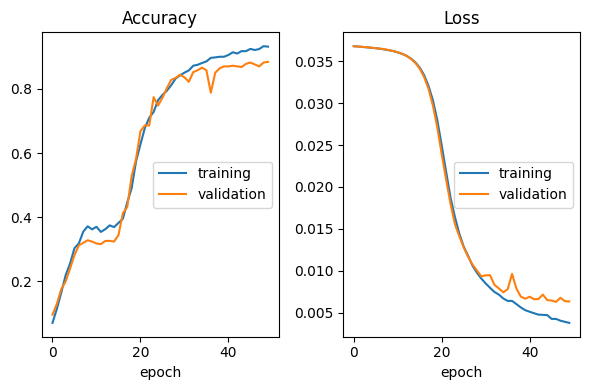

Test loss = 0.0066, Test Accuracy = 0.872


In [11]:
# TASK 1 EXERCISE

# Adjust the Hyperparameters to Identify an instance of overfitting
learning_rate = 0.01
n_epochs = 50
fc_network = FullyConnectedNetwork(hidden_layers = 3, hidden_nodes = 250)
fc_network.to(device)
fc_optimizer = optim.SGD(fc_network.parameters(), lr=learning_rate)

plotlosses = PlotLosses(outputs=[MatplotlibPlot(cell_size = (3, 2))])

for epoch in range(n_epochs):

  print("Current Epoch: " + str(epoch))

  train_loss, train_acc = trainer(fc_network, fc_optimizer, device)
  val_loss, val_acc = tester(fc_network, val_loader, device)

  plotlosses.update({'acc': train_acc, 'val_acc': val_acc, 'loss': train_loss, 'val_loss': val_loss})
  plotlosses.draw()  # draw, update logs, etc

# Following your training procedure, remember to assess the performance of your model on your test data
test_loss, test_acc = tester(fc_network, test_loader, device)
print("Test loss = {loss}, Test Accuracy = {acc}".format(loss=round(test_loss, 4), acc=round(test_acc, 4)))

## Model Validation with Cross-fold Validation for Neural Networks

Tasks:
1. Run the following code to implement k-fold cross validation on this dataset.
  - Analyze the results.

In [12]:
# TASK 1 EXERCISE AND SOLUTION

from torch.utils.data import DataLoader, Subset, SubsetRandomSampler

# Set up k-fold cross-validation
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Set some hyperparameters
num_epochs = 10

# Prepare results storage
fold_accuracies = []
fold_losses = []

# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(train_set)):
    print(f"Training fold {fold + 1}/{k}")

    # SubsetRandomSampler for train and validation splits
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    # Use DataLoader with these samplers
    train_loader = DataLoader(train_set, sampler=train_sampler, batch_size=batch_size)
    val_loader = DataLoader(train_set, sampler=val_sampler, batch_size=batch_size)

    # Define the neural network model
    class NeuralNet(nn.Module):
        def __init__(self):
            super(NeuralNet, self).__init__()
            self.fc1 = nn.Linear(28 * 28, 16)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(16, 10)  # 10 output classes (digits 0-9)

        def forward(self, x):
            x = x.view(x.size(0), -1)  # Flatten the image
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)
            return x

    # Initialize the model, loss, and optimizer
    model = NeuralNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluation loop
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    accuracy = correct / total
    fold_accuracies.append(accuracy)
    fold_losses.append(val_loss / len(val_loader))

    print(f"Fold {fold + 1} - Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

# Calculate overall performance
average_accuracy = sum(fold_accuracies) / k
average_loss = sum(fold_losses) / k
print("\nK-Fold Cross-Validation Results:")
print(f"Average Accuracy: {average_accuracy:.4f}")
print(f"Average Loss: {average_loss:.4f}")


Training fold 1/5
Fold 1 - Loss: 3.6473, Accuracy: 0.8900
Training fold 2/5
Fold 2 - Loss: 4.0306, Accuracy: 0.8840
Training fold 3/5
Fold 3 - Loss: 3.9388, Accuracy: 0.8880
Training fold 4/5
Fold 4 - Loss: 5.4703, Accuracy: 0.8300
Training fold 5/5
Fold 5 - Loss: 3.3175, Accuracy: 0.9000

K-Fold Cross-Validation Results:
Average Accuracy: 0.8784
Average Loss: 0.5101


## Dropout Layers

When training deep neural networks, one common challenge is **overfitting**, where the model learns patterns that are specific to the training data but do not generalize well to unseen data. To combat this, **dropout** is a widely used regularization technique that randomly **"drops"** a fraction of the neurons in the network during each training step, preventing the model from becoming overly reliant on any specific neurons. This forces the network to learn more robust features and improves its ability to generalize.

The following code defines a **fully connected neural network** with **dropout layers** integrated into its architecture. The **DropoutNetwork** class allows you to configure the number of hidden layers, the number of nodes per layer, and the **dropout probability**, which controls how many neurons are randomly dropped during training. This modular implementation makes it easy to adjust the network's complexity and regularization strength to suit different tasks and datasets.

In [13]:
from torch.nn import Dropout

# Define a fully connected network with dropout layers to improve generalization
class DropoutNetwork(nn.Module):
    def __init__(self, hidden_layers=2, hidden_nodes=10, p=0.1):
        """
        Initializes the DropoutNetwork.

        Args:
            hidden_layers (int): The number of hidden layers in the network.
            hidden_nodes (int): The number of nodes in each hidden layer.
            p (float): The dropout probability, controlling how many neurons are randomly zeroed out.
        """
        super(DropoutNetwork, self).__init__()

        layers = list()  # Initialize an empty list to hold the network layers

        # Add the input layer (784 input features for a typical flattened image input)
        layers.append(Linear(784, hidden_nodes))
        layers.append(ReLU())  # Apply ReLU activation to introduce non-linearity

        # Loop to create the specified number of hidden layers
        for _ in range(hidden_layers):
            # Add a fully connected hidden layer
            layers.append(Linear(hidden_nodes, hidden_nodes))

            # Add a dropout layer to randomly zero out a fraction of neurons, reducing overfitting
            layers.append(Dropout(p=p))

            # Apply ReLU activation after the dropout layer
            layers.append(ReLU())

        # Add the output layer (10 output features for a typical classification task with 10 classes)
        layers.append(Linear(hidden_nodes, 10))

        # Chain the layers together using nn.Sequential
        self.mlp = Sequential(*layers)

    def forward(self, input_data):
        """
        Forward pass of the network.

        Args:
            input_data (Tensor): The input data to the network.

        Returns:
            Tensor: The output predictions from the network.
        """
        return self.mlp(input_data)

### EXERCISE: Effects of Dropout on Overfitting

Tasks:
- Adjust the $p$ parameter, and see how this affects model training performance.
  - Try three different values, and note how the plotted loss curves change as $p$ gets closer to 1.

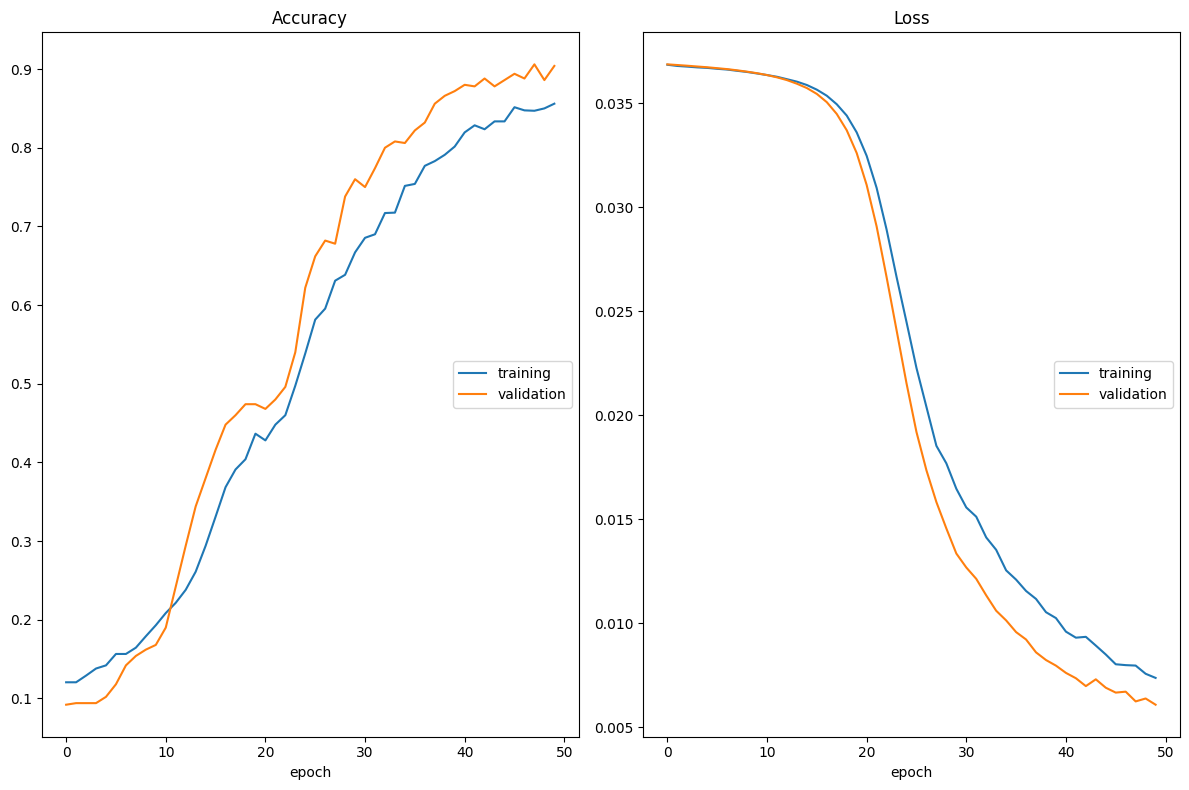

Accuracy
	training         	 (min:    0.121, max:    0.856, cur:    0.856)
	validation       	 (min:    0.092, max:    0.906, cur:    0.904)
Loss
	training         	 (min:    0.007, max:    0.037, cur:    0.007)
	validation       	 (min:    0.006, max:    0.037, cur:    0.006)
Test loss = 0.0076, Test Accuracy = 0.872


In [14]:
# TASK 1 EXERCISE

plotlosses = PlotLosses()

p = 0.3 # DEFAULT VALUE IS .3

# create network and optimizer
learning_rate = 0.01
n_epochs = 50

# TODO: Create DropoutNetwork with same NN parameters from Exercise 1 (for which you saw overfitting)
drop_network = DropoutNetwork(hidden_layers=3, hidden_nodes = 250, p=p)

drop_network.to(device)

drop_optimizer = optim.SGD(drop_network.parameters(), lr=learning_rate)

for epoch in range(n_epochs):
  train_loss, train_acc = trainer(drop_network, drop_optimizer, device)
  val_loss, val_acc = tester(drop_network, val_loader, device)

  plotlosses.update({'acc': train_acc, 'val_acc': val_acc, 'loss': train_loss, 'val_loss': val_loss})
  plotlosses.draw()  # draw, update logs, etc

test_loss, test_acc = tester(drop_network, test_loader, device)
print("Test loss = {loss}, Test Accuracy = {acc}".format(loss=round(test_loss, 4), acc=round(test_acc, 4)))

## Early Stopping

Early stopping is a regularization technique used to prevent overfitting during model training. It works by monitoring the model's performance on the validation set and stopping the training process once the performance stops improving.  

The key advantage of early stopping is that it helps save time and resources by avoiding unnecessary training cycles, while also improving the model's generalization to unseen data. A critical parameter to tune in early stopping is **`patience`**, which defines how many epochs the model will wait before stopping if no further improvement is observed.  

This approach ensures the model trains efficiently without overfitting to the training data.

### EXERCISE: Early Stopping

In this exercise, you'll implement an early stopping callback within a training loop to prevent overfitting and optimize training time.

The key parameter to focus on is `patience`, which defines how many epochs the model will wait without improvement in validation performance or loss before halting training. Tuning this parameter helps strike a balance between giving the model enough time to improve and stopping it before unnecessary training cycles.

Tasks:
1. Experiment with different `patience` values and observe how they impact validation accuracy and the overall training process.


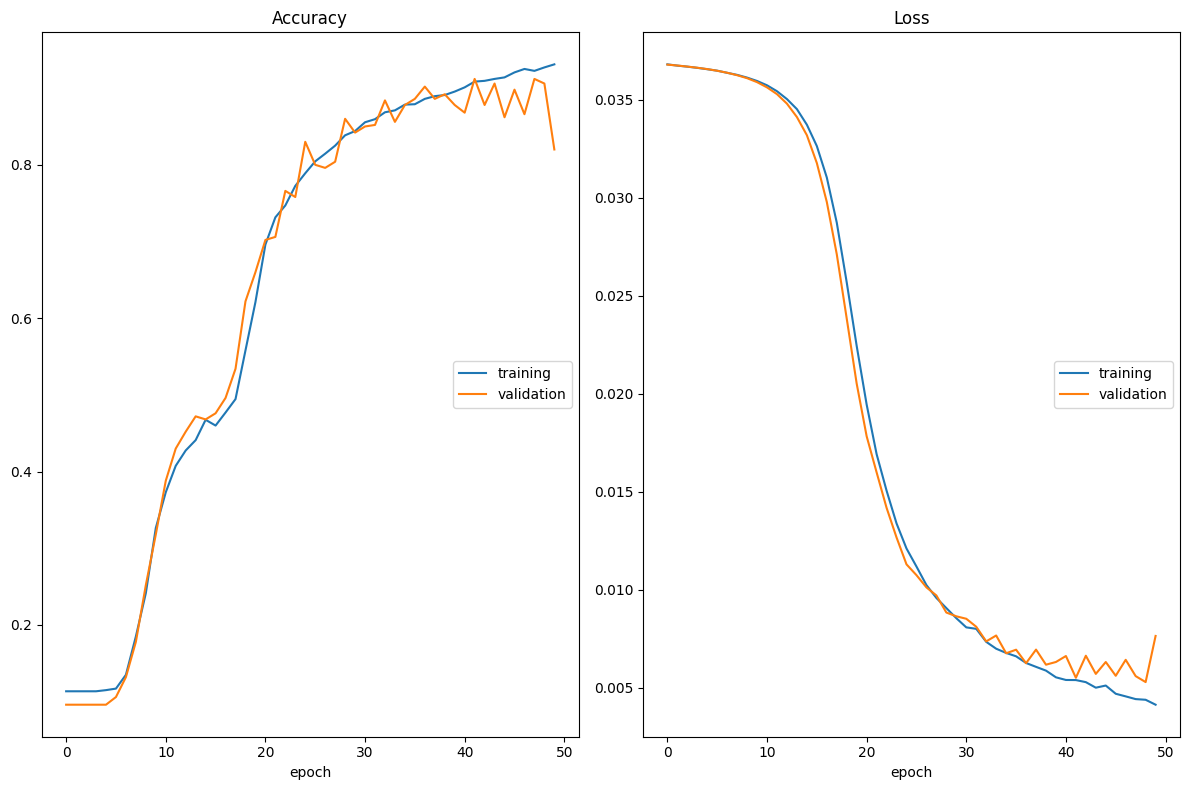

Accuracy
	training         	 (min:    0.114, max:    0.931, cur:    0.931)
	validation       	 (min:    0.096, max:    0.912, cur:    0.820)
Loss
	training         	 (min:    0.004, max:    0.037, cur:    0.004)
	validation       	 (min:    0.005, max:    0.037, cur:    0.008)
The Current Loss: 0.00763475289568305
Trigger Times: 1
Test loss = 0.0085, Test Accuracy = 0.852


In [15]:
# TASK 1 EXERCISE

learning_rate = 0.01
n_epochs = 50
fc_network = FullyConnectedNetwork(hidden_layers = 3, hidden_nodes = 250)
fc_network.to(device)
fc_optimizer = optim.SGD(fc_network.parameters(), lr=learning_rate)

patience = 3 # Try values 1, 2, 3, 4, 5

plotlosses = PlotLosses()
# Train 1st epoch separately
train_loss, train_acc = trainer(fc_network, fc_optimizer, device)
val_loss, val_acc = tester(fc_network, val_loader, device)

plotlosses.update({'acc': train_acc, 'val_acc': val_acc, 'loss': train_loss, 'val_loss': val_loss})
plotlosses.draw()  # draw, update logs, etc

# Early stopping
last_loss = val_loss
triggertimes = 0

# Train remaining epochs
for epoch in range(1,n_epochs):

  # Save latest model
  latest_model = fc_network

  train_loss, train_acc = trainer(fc_network, fc_optimizer, device)
  val_loss, val_acc = tester(fc_network, val_loader, device)

  plotlosses.update({'acc': train_acc, 'val_acc': val_acc, 'loss': train_loss, 'val_loss': val_loss})
  plotlosses.draw()  # draw, update logs, etc

  current_loss = val_loss

  print('The Current Loss:', current_loss)

  if current_loss > last_loss:

      trigger_times += 1
      print('Trigger Times:', trigger_times)

      if trigger_times >= patience:
          print('Early stopping!\nStart to test process.')
          break

  else:
    print('trigger times: 0')
    trigger_times = 0

  last_loss = current_loss

test_loss, test_acc = tester(fc_network, test_loader, device)
print("Test loss = {loss}, Test Accuracy = {acc}".format(loss=round(test_loss, 4), acc=round(test_acc, 4)))

## Batch Normalization

Batch Normalization is a technique used to **improve the training process** of deep neural networks by **normalizing the inputs** of each layer. It reduces the **internal covariate shift** — a phenomenon where the **distribution of inputs** to a layer changes during training — by ensuring that the inputs to each layer have a **consistent mean and variance**.

This normalization helps **stabilize** and **speed up** the training process, allowing the model to **converge faster** and **perform better**. It also acts as a **regularizer**, reducing the need for other methods like **dropout** in some cases.

In practice, Batch Normalization is applied **after the linear transformations** (like **fully connected layers** or **convolutional layers**) but **before applying the activation function**. By **maintaining stable input distributions**, it enables the use of **higher learning rates** and makes the network more **robust to parameter initialization**.

### EXERCISE: Effects of Batch Normalization on Overfitting

In this exercise, we'll explore how batch normalization can improve neural network performance by stabilizing the training process and reducing internal covariate shift. You'll implement batch normalization layers and observe their effects on model training and validation performance.

Tasks:
1. Introduce batch normalization into a neural network using the `BatchNorm1d(~)` function.
2. Using the `BatchNormNetwork(~)` and the previous exercises to see how introducing batch normalization can lead to reductions in overfitting. You can then manipulate the hyperparameters to see how Batch Normalization interacts with different values for `hidden_layers`, `hidden_nodes`, and `learning_rate`.


#### TASK 1: Introduce Batch Normalization

In [17]:
# TASK 1 EXERCISE

from torch.nn import BatchNorm1d

class BatchNormNetwork(nn.Module):
  def __init__(self,  hidden_layers=2, hidden_nodes=10):
    super(BatchNormNetwork, self).__init__()
    layers = list()

    layers.append(Linear(784, hidden_nodes))            # input layer
    layers.append(ReLU())
    for hdim in range(hidden_layers):                   # create hidden layers
      layers.append(Linear(hidden_nodes, hidden_nodes))
      layers.append(ReLU())

      # TODO: Add 1D batch normalization to all hidden nodes
      # Append BatchNorm1d layer
      layers.append(BatchNorm1d(hidden_nodes))

    layers.append(Linear(hidden_nodes, 10))             # output layer

    self.mlp = Sequential(*layers)                      # chain together

  def forward(self, input_data):
    return self.mlp(input_data)


#### TASK 2: Train a BatchNormNetworK

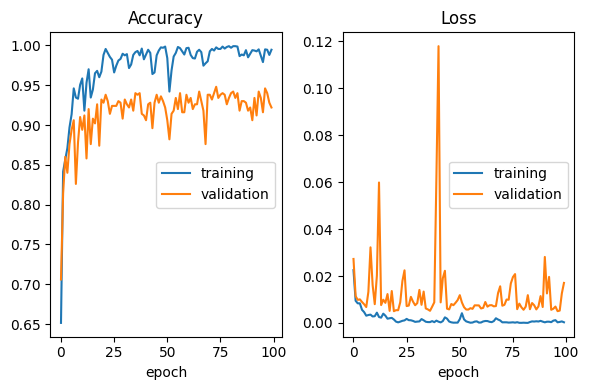

Test loss = 0.0058, Test Accuracy = 0.924


In [18]:
# TASK 2 EXERCISE

# Here is an example set of parameters that leads to overfitting
learning_rate = .01
n_epochs = 100
hidden_layers = 3
hidden_nodes = 1000

# Use the BatchNormNetwork
batch_network = BatchNormNetwork(hidden_layers=hidden_layers, hidden_nodes=hidden_nodes)
batch_network.to(device)
batch_optimizer = torch.optim.Adam(batch_network.parameters(), lr=learning_rate)

plotlosses = PlotLosses(outputs=[MatplotlibPlot(cell_size = (3, 2))])

for epoch in range(n_epochs):

  print("Current Epoch: " + str(epoch))

  train_loss, train_acc = trainer(batch_network, batch_optimizer, device)
  val_loss, val_acc = tester(batch_network, val_loader, device)

  plotlosses.update({'acc': train_acc, 'val_acc': val_acc, 'loss': train_loss, 'val_loss': val_loss})
  plotlosses.draw()  # draw, update logs, etc

# Following your training procedure, remember to assess the performance of your model on your test data
test_loss, test_acc = tester(batch_network, test_loader, device)
print("Test loss = {loss}, Test Accuracy = {acc}".format(loss=round(test_loss, 4), acc=round(test_acc, 4)))

## Modify learning rate and optimizer

We won't be covering it here but you can also set a desired time-varying learning rate schedule as well, using the `torch.optim.lr_scheduler` option in PyTorch.

Some examples include exponential learning rates and ReduceLROnPlateau.

You can learn about the different types of optimizers and learning rate schedulers available in PyTorch [here](https://https://pytorch.org/docs/stable/optim.html).

#### TASK 1: Experiment with different optimization algorithms, learning rates and schedulers to see how it affects **training time and accuracy**. Compare the **convergence time** to the runs above.

Modify your train function to use a scheduler

In [22]:
def trainer_scheduler(network, optimizer, device, flatten_data=True):
    """
    Trains the given network for one epoch.

    Args:
        network (nn.Module): The neural network model to train.
        optimizer (torch.optim.Optimizer): The optimizer to apply during backpropagation.
        device (str): The device type ('cpu' or 'cuda') to use for training.
        flatten_data (bool): Whether to flatten the input images into vectors (True for fully connected networks).

    Returns:
        (float, float): A tuple (loss_ratio, correct_ratio) representing the average loss
                        per example and overall accuracy after one epoch of training.
    """
    network.train()  # Set the model to training mode

    # Initialize accumulators for loss and accuracy calculations
    total_loss = 0
    total_correct = 0
    total_items = 0

    # TODO: Create scheduler


    for batch_idx, (data, target) in enumerate(train_loader):

        # Transfer the data and target to the specified device (GPU/CPU)
        data, target = data.to(device), target.to(device)

        # Flatten the data if using fully connected layers
        if flatten_data:
            data = flatten(data)

        # Forward pass: get model predictions
        output = network(data)

        # Compute batch loss (CrossEntropy is well-suited for multi-class classification)
        loss_fn = CrossEntropyLoss()
        loss = loss_fn(output, target)

        # Reset gradients from the previous iteration
        optimizer.zero_grad()

        # Backpropagation: compute gradients
        loss.backward()

        # Parameter update step
        optimizer.step()

        # TODO: Scheduler step

        # Accumulate metrics
        total_loss += loss
        total_correct += torch.sum(torch.argmax(output, dim=1) == target)
        total_items += len(target)

        # Calculate average loss and accuracy so far
        loss_ratio = (total_loss / total_items).item()
        correct_ratio = (total_correct / total_items).item()

        # Note: .item() converts a scalar tensor to a Python float (and moves it to CPU if on GPU)

    return loss_ratio, correct_ratio


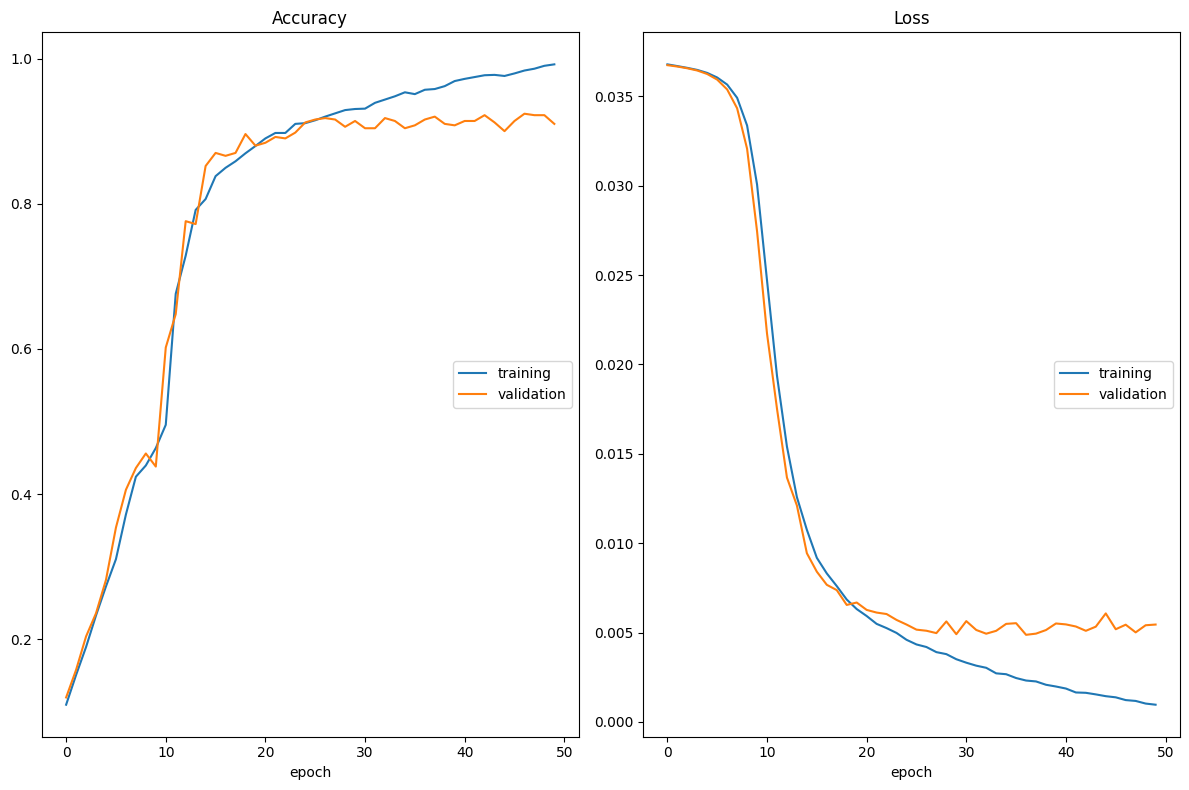

Accuracy
	training         	 (min:    0.110, max:    0.992, cur:    0.992)
	validation       	 (min:    0.120, max:    0.924, cur:    0.910)
Loss
	training         	 (min:    0.001, max:    0.037, cur:    0.001)
	validation       	 (min:    0.005, max:    0.037, cur:    0.005)
CPU times: user 47.3 s, sys: 374 ms, total: 47.6 s
Wall time: 49 s


In [24]:
# Record convergence time
%%time

plotlosses = PlotLosses()

learning_rate = 0.01 # TODO: Change me!
n_epochs = 50
fc_network = FullyConnectedNetwork(hidden_layers = 3, hidden_nodes = 250)
fc_network.to(device)

# Add momentum term
momentum = 0.5 # TODO: Change me!

# TODO: Try out different optimizers {SGD, Adam, RMSprop, Adadelta}
fc_optimizer = optim.SGD(fc_network.parameters(), lr=learning_rate, momentum=momentum)

for epoch in range(n_epochs):

  train_loss, train_acc = trainer_scheduler(fc_network, fc_optimizer, device)
  val_loss, val_acc = tester(fc_network, val_loader, device)

  plotlosses.update({'acc': train_acc, 'val_acc': val_acc, 'loss': train_loss, 'val_loss': val_loss})
  plotlosses.draw()  # draw, update logs, etc


In [25]:
test_loss, test_acc = tester(fc_network, test_loader, device)
print("Test loss = {loss}, Test Accuracy = {acc}".format(loss=round(test_loss, 4), acc=round(test_acc, 4)))

Test loss = 0.0057, Test Accuracy = 0.924
